In [1]:
#Classification of MNIST dataset 
push!(LOAD_PATH, "/home/jberez/Projects/MNIST/dockeropt")

using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Random
using Distances
using Flux
using StatsBase
using MultivariateStats
using IterTools #Only for plots, not for program
using Serialization

include("dockeropt/proposals.jl")
#include("dockeropt/LoadData.jl")
include("dockeropt/utils.jl")
include("dockeropt/NUTS.jl");

In [3]:
#Read Optdigits CSV
#using CSV
#using DataFrames

#test = CSV.read("dockeropt/optdigits.csv", DataFrame)
#y_total = Array(test[:,65]) .+ 1
#x_total = Array(test[:,1:64]);
#x_total = [Float64(i) for i in x_total]
x_total = deserialize("dockeropt/optdigits_x.jld")
y_total = deserialize("dockeropt/optdigits_y.jld")

#display(x_total[1:5,:])

dx = fit(ZScoreTransform, x_total, dims=2)
StatsBase.transform!(dx, x_total)

#display(x_total[1:5,:])

5620×64 Array{Float64,2}:
 -0.88024   -0.694315   0.235312   …  -0.694315    -0.88024   -0.88024
 -0.930922  -0.930922   0.692484      -0.4439      -0.930922  -0.930922
 -0.783024  -0.783024   0.481671      -0.783024    -0.783024  -0.783024
 -0.772202  -0.772202  -0.772202      -0.448131    -0.772202  -0.772202
 -0.783586  -0.783586   0.159074       0.536138    -0.783586  -0.783586
 -0.913147  -0.913147   0.843288   …   1.64167      1.64167    0.0449088
 -0.772227  -0.772227  -0.5885        -0.772227    -0.772227  -0.772227
 -0.795272  -0.795272   0.696227      -0.795272    -0.795272  -0.795272
 -0.943851  -0.943851   1.60853       -0.943851    -0.943851  -0.943851
 -0.972891  -0.972891  -0.482615       0.00766056  -0.972891  -0.972891
 -0.834477  -0.834477   0.116381   …  -0.834477    -0.834477  -0.834477
 -0.793296  -0.793296  -0.793296       1.38705     -0.637557  -0.793296
 -0.901466  -0.901466  -0.901466      -0.267468    -0.901466  -0.901466
  ⋮                                ⋱  

In [8]:
#Load Train and Test Sets

function balanced_set(x,y,n,c,seed=0)
    
    if seed != 0
        Random.seed!(seed)
    end
    
    shuffled_indices = shuffle(1:length(y))
    x = x[shuffled_indices,:]
    y = y[shuffled_indices]
    
    x_ordered = zeros(Float64,n*c,64)
    y_ordered = zeros(Int,n*c)
    for k=1:c
        labels = [i for i in 1:length(y) if y[i]==k]
        x_ordered[k*n-(n-1):k*n,:] = x[labels,:][1:n,:]
        y_ordered[k*n-(n-1):k*n] = y[labels][1:n]
    end
    return x_ordered, y_ordered
end

function reshape_x(x)
    n = size(x)[1]
    println(n)
    x_reshaped = zeros(Float64, 8, 8, n)
    for i=1:n
        test = reshape(x[i,:], (1,8,8))
        x_reshaped[:,:,i] = reshape(x[i,:], (8,8))
    end
    return x_reshaped
end;

#Load the OptDigits Data
num_samples = 10
num_classes = 10

x_train, y_train = balanced_set(x_total,y_total,num_samples,num_classes,1);
x_test, y_test = balanced_set(x_total,y_total,num_samples,num_classes,10);

display(x_train[1:5,:])
display(x_test[1:5,:])

5×64 Array{Float64,2}:
 -0.814917  -0.814917  -0.228909   …  -0.0335734  -0.814917  -0.814917
 -0.762098  -0.762098  -0.762098       2.18276    -0.39399   -0.762098
 -0.895293  -0.895293  -0.895293       0.549213   -0.895293  -0.895293
 -0.909617  -0.909617  -0.0683527      0.0999002  -0.909617  -0.909617
 -0.956471  -0.956471  -0.122491       1.21188    -0.789675  -0.956471

5×64 Array{Float64,2}:
 -0.861088  -0.861088   0.0192576  …   0.899604   -0.861088  -0.861088
 -0.844923  -0.844923   1.18797       -0.844923   -0.844923  -0.844923
 -0.847889  -0.847889   0.921618      -0.258053   -0.847889  -0.847889
 -0.818558  -0.818558   0.151585      -0.0101057  -0.818558  -0.818558
 -0.839001  -0.839001  -0.839001      -0.507544   -0.839001  -0.839001

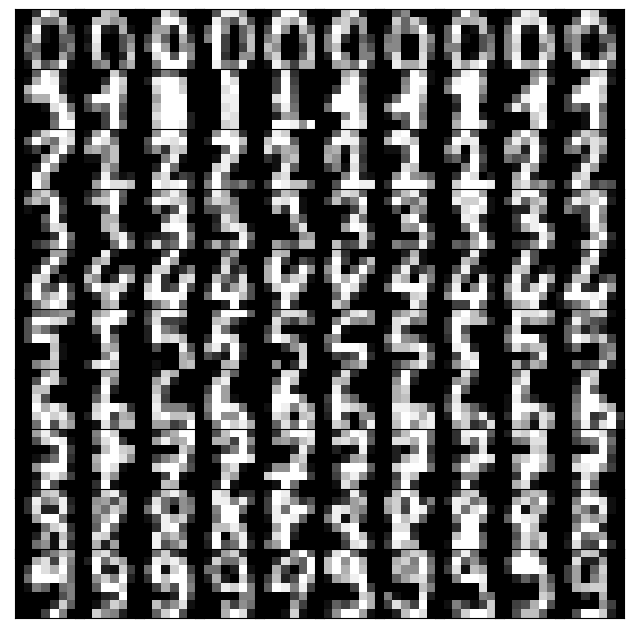

100


In [9]:
#Visualize Samples
x_reshaped = reshape_x(x_train)

nrow, ncol = num_classes,num_samples 
fig = figure("plot_mnist",figsize=(6,6))
for (i, (c, r)) in enumerate(Iterators.product(1:ncol, 1:nrow))
    subplot(nrow, ncol, i)
    imshow(x_reshaped[:,:,i]', cmap="gray")
    ax = gca()
    ax.xaxis.set_visible(false)
    ax.yaxis.set_visible(false)
end;
tight_layout(w_pad=-1, h_pad=-1, pad=-0.5);

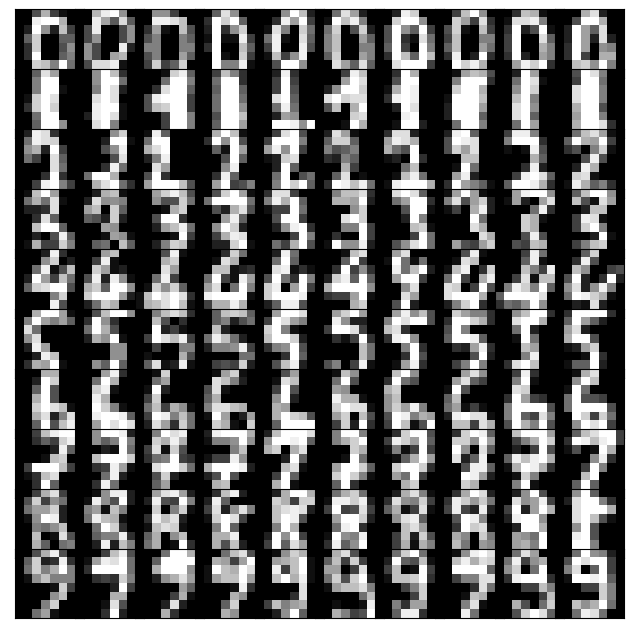

100


In [10]:
#Visualize Samples
x_reshaped = reshape_x(x_test)

nrow, ncol = num_classes,num_samples 
fig = figure("plot_mnist",figsize=(6,6))
for (i, (c, r)) in enumerate(Iterators.product(1:ncol, 1:nrow))
    subplot(nrow, ncol, i)
    imshow(x_reshaped[:,:,i]', cmap="gray")
    ax = gca()
    ax.xaxis.set_visible(false)
    ax.yaxis.set_visible(false)
end;
tight_layout(w_pad=-1, h_pad=-1, pad=-0.5);

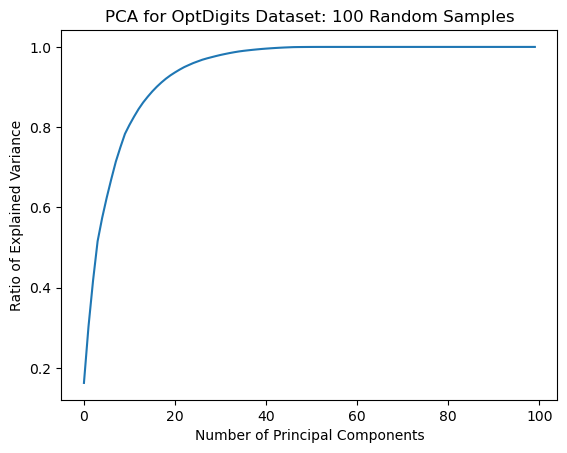

In [11]:
#Run PCA to lower dimensionality of MNIST
vars = []
x = transpose(x_train)
for i=1:100    
    MNIST_PCA = fit(PCA, x, maxoutdim=i, pratio=1.0)
    push!(vars,MNIST_PCA.tprinvar/MNIST_PCA.tvar)
end
plot(vars)
plt.title("PCA for OptDigits Dataset: 100 Random Samples")
plt.xlabel("Number of Principal Components")
plt.ylabel("Ratio of Explained Variance");

In [12]:
#Get PCA Transform for x
dims = 20
x_pca = fit(PCA,x,maxoutdim=dims)
xt = MultivariateStats.transform(x_pca,x)

#Testing PCA Transform
xz = MultivariateStats.transform(x_pca,transpose(x_test));

In [13]:
#One-Hot Encode Y
y = y_train
yt = Flux.onehotbatch(y,[:1,:2,:3,:4,:5,:6,:7,:8,:9,:10]);
#Test Set
yz = y_test
yzt = Flux.onehotbatch(yz,[:1,:2,:3,:4,:5,:6,:7,:8,:9,:10]);

In [14]:
#------------------------------------
#Hyperparameters and Helper Functions
#------------------------------------

#Select Network Goal
network = "classifier"

#Data hyperparameters
n = num_samples #Number of samples
c = num_classes #Number of classes
d = dims #Input dimension
N = n*c #Total samples

#Node hyperparameters
k_range = 20 #Maximum number of neurons per layer
k_list = [Int(i) for i in 1:k_range]

#NUTS
Δ_max = 1000;

In [41]:
#New Softmax
function softmax_(arr::AbstractArray)
    ex = mapslices(x -> exp.(0.9*x),arr,dims=1)
    rows, cols = size(arr)
    val = similar(ex)
    for i in 1:cols
        s = sum(ex[:,i])
        for j in 1:rows
            val[j,i] = ex[j,i]/s
        end
    end
    return val
end;

In [42]:
#Bayesian Neural Net
function G(x, trace)
    activation = tanh
    layers = trace[:l]
    ks = [trace[(:k,i)] for i=1:layers]
    
    for i=1:layers
        in_dim, out_dim = layer_unpacker(i, layers, ks)
        W = reshape(trace[(:W,i)], out_dim, in_dim)
        b = reshape(trace[(:b,i)], trace[(:k,i)])
        nn = Dense(W, b, activation)
        x = nn(x)
    end
    
    Wₒ = reshape(trace[(:W,layers+1)], c, ks[layers])
    bₒ = reshape(trace[(:b,layers+1)], c)
    
    nn_out = Dense(Wₒ, bₒ)
    x = nn_out(x)
    
    return softmax_(x)
end;

In [43]:
@gen function classifier(x::Array{Float64})
    
    #Create a blank choicemap
    obs = choicemap()::ChoiceMap
    
    #Draw number of layers - 1 for Classifier Net
    l ~ categorical([1.0])
    l_real = l
    obs[:l] = l
    
    #Create individual weight and bias vectors
    #Loop through hidden layers
    k = [Int(0) for i=1:l+1]
    for i=1:l
        k[i] = @trace(categorical([1/length(k_list) for i=1:length(k_list)]), (:k,i))
        obs[(:k,i)] = k[i]
    end
    output_array = zeros(Float64, c)
    output_array[c] = 1.0

    k[l+1] = @trace(categorical(output_array), (:k,l+1))
    obs[(:k,l+1)] = k[l+1]
    
    ########################################
    #Fixed Hyperparameter schedule - Apr 26#
    ########################################
    
    σ = 1.0
    
    #Sample weight and bias vectors
    W = [zeros(k[i]) for i=1:l+1]
    b = [zeros(k[i]) for i=1:l+1]

    for i=1:l+1
        if i == 1
            h = Int(d * k[i])
        else
            h = Int(k[i-1] * k[i])
        end

        if i<=l
            #Hidden Weights
            u = zeros(h)
            S = Diagonal([σ for j=1:length(u)])
            W[i] = @trace(mvnormal(u,S), (:W,i))
            obs[(:W,i)] = W[i]
            
            #Hidden Biases
            ub = zeros(k[i])
            Sb = Diagonal([σ for j=1:length(ub)])   
            b[i] = @trace(mvnormal(ub,Sb), (:b,i))
            obs[(:b,i)] = b[i]
        else
            #Output Weights
            u = zeros(h)
            S = Diagonal([σ for j=1:length(u)])
            W[i] = @trace(mvnormal(u,S), (:W,i))
            obs[(:W,i)] = W[i]

            #Output Bias
            ub = zeros(c)
            Sb = Diagonal([σ for j=1:length(ub)]) 
            b[i] = @trace(mvnormal(ub,Sb), (:b,i))
            obs[(:b,i)] = b[i]
        end
    end
    
    #Return Network Scores for X
    scores = G(x,obs)
    
    #Logistic Classification Likelihood
    y = zeros(length(scores))
    for j=1:length(x[1,:])
        score_vec = scores[:,j]
        #println(score_vec)
        y[j] = @trace(categorical(score_vec), (:y,j))
    end
    
    return scores
    
end;

obs_master = choicemap()::ChoiceMap
for i=1:length(y)
    obs_master[(:y,i)] = y[i]
end
obs = obs_master;

(best_trace,) = generate(classifier, (xt,), obs)
println(get_score(best_trace))
println(best_trace[(:k,1)])
test_labels = G(xt,best_trace)
results = label_output(test_labels)
test_acc = sum([y[i] == results[i] for i=1:length(y)])

-559.1664345349968
5


10

In [44]:
function find_best_trace(x,y,iters,obs)
    scores = []
    single_traces = []
    for i = 1:1000
        (trace,) = generate(classifier, (x,), obs)
        push!(scores,get_score(trace))
        push!(single_traces,trace)
    end
    best_trace = single_traces[findmax(scores)[2]];
    return best_trace
end

new_start = find_best_trace(xt,y,100,obs)
score = get_score(new_start)
println("Chain starting score: $score")

Chain starting score: -300.5072564630974


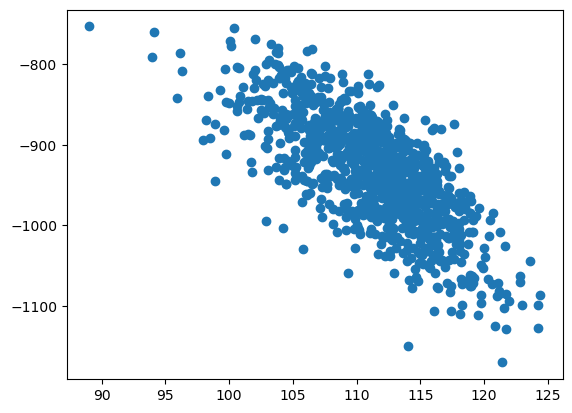

-753.4856007022082


In [45]:
#Test Likelihood
obs_master = choicemap()::ChoiceMap
for i=1:length(y)
    obs_master[(:y,i)] = y[i]
end
obs = obs_master;

obs[(:k,1)] = 10
scores = []
accs = []
traces = []
ks = []
for i = 1:1000
    (trace,) = generate(classifier, (xt,), obs)
    push!(ks,trace[(:k,1)])
    push!(scores,get_score(trace))
    push!(traces,trace)
    test_labels = G(xt,trace)
    results = label_output(test_labels)
    test_acc = sum([y[i] == results[i] for i=1:length(y)])/length(y)
    test_acc = sum([euclidean(yt[:,j],test_labels[:,j]) for j=1:length(y)])
    push!(accs,test_acc)
end

scatter(accs,scores)
#plt.xlim(50,300)
#plt.ylim(-2000,0)
#println(ks)
best_trace = traces[findmax(scores)[2]];
println(get_score(best_trace))

In [46]:
#-------------
#Run Inference
#-------------

include("NUTS.jl")
Δ_max = 10
acc_prob = 0.65
#Random.seed!(1)

scores = []
traces = []
ks = []
across_acceptance = []
within_acceptance = []

#Inference Hyperparameters
across_iters = 1
m = 3

function nuts_parameters(trace)
    
    l = trace[:l]
    param_selection = select()
    for i=1:l+1 #Number of Layers
        push!(param_selection, (:W,i))
        push!(param_selection, (:b,i))
    end
    
    prev_score = get_score(trace)

    new_trace = NUTS(trace, param_selection, acc_prob, m, m, false)[m+1]
    new_score = get_score(new_trace)
    nuts_score = new_score - prev_score
    
    if exp(nuts_score) == 1
        accepted = 0
        return (trace, accepted)
    else
        accepted = 1
        return (new_trace, accepted)
    end

end

function node_parameter(trace)
    obs = obs_master
    
    init_trace = trace
    
    #################################################RJNUTS#################################################
    #NUTS Step 1
    trace_tilde = trace
    for i=1:across_iters
        (trace_tilde,) = nuts_parameters(trace_tilde)
    end
    
    #Reversible Jump Step
    (trace_prime, q_weight) = node_change(trace_tilde)
    
    #NUTS Step 2
    trace_star = trace_prime
    for i=1:across_iters
        (trace_star,) = nuts_parameters(trace_star)
    end
    #################################################RJNUTS#################################################
        
    model_score = -get_score(init_trace) + get_score(trace_star)
    across_score = model_score + q_weight

    if rand() < exp(across_score)
        println("********** Accepted: $(trace_star[(:k,1)]) **********")
        return (trace_star, 1)
    else
        return (init_trace, 0)
    end
end

obs_master = choicemap()::ChoiceMap
for i=1:length(y)
    obs_master[(:y,i)] = y[i]
end
obs = obs_master;

#(trace,) = generate(classifier, (xt,), obs)
trace = best_trace
starting_k = trace[(:k,1)]
println("Starting k: $starting_k")
traces = []

for i=1:300
    (trace, accepted) = node_parameter(trace)
    push!(across_acceptance, accepted)
    (trace, accepted) = nuts_parameters(trace)
    push!(within_acceptance, accepted)
    push!(scores,get_score(trace))
    push!(traces, trace)
    println("$i : $(get_score(trace))")
    flush(stdout)
    if i%10 == 0
        a_acc = 100*(sum(across_acceptance)/length(across_acceptance))
        w_acc = 100*(sum(within_acceptance)/length(within_acceptance))
        println("Epoch $i A Acceptance Probability: $a_acc %")
        println("Epoch $i W Acceptance Probability: $w_acc %")
    end
end

Starting k: 10
1 : -753.4856007022082
2 : -753.4856007022082
********** Accepted: 11 **********
3 : -797.0937866862184
********** Accepted: 10 **********
4 : -729.3009109543378
5 : -729.3009109543378
********** Accepted: 9 **********
6 : -664.106328748373
7 : -664.106328748373
8 : -664.106328748373
********** Accepted: 8 **********
9 : -611.0122136651248
10 : -612.0271005671428
Epoch 10 A Acceptance Probability: 40.0 %
Epoch 10 W Acceptance Probability: 20.0 %
11 : -612.0271005671428
12 : -612.0271005671428
13 : -612.062775439534
14 : -613.5938840254531
15 : -589.1799722279602
16 : -587.1231055291153
********** Accepted: 7 **********
17 : -521.6616958137851
18 : -513.7982975659913
19 : -513.7982975659913
20 : -514.9672625117977
Epoch 20 A Acceptance Probability: 25.0 %
Epoch 20 W Acceptance Probability: 40.0 %
********** Accepted: 8 **********
21 : -551.7578551917536
22 : -557.3855136445057
23 : -556.6853940333422
24 : -557.7352642416661
********** Accepted: 9 **********
25 : -593.0178

InterruptException: InterruptException:

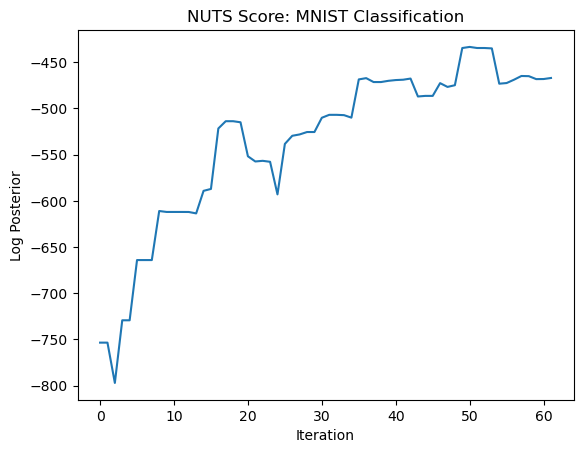

In [47]:
#Log Posterior Score Chart
obs_master = choicemap()::ChoiceMap
for i=1:length(y)
    obs_master[(:y,i)] = y[i]
end
obs = obs_master;

plot([get_score(trace) for trace in traces])
plt.title("NUTS Score: MNIST Classification")
plt.xlabel("Iteration")
plt.ylabel("Log Posterior");

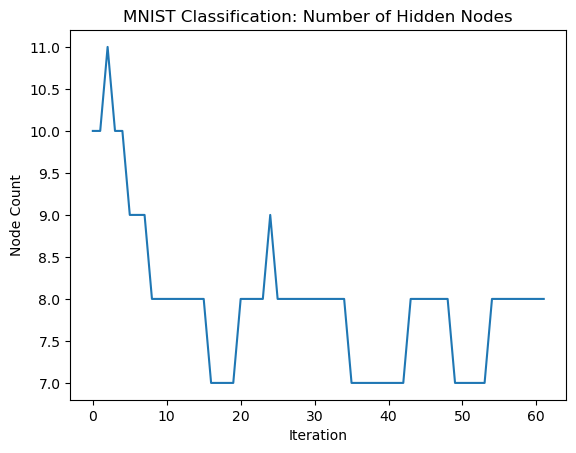

In [48]:
#Node Count Chart

plot([trace[(:k,1)] for trace in traces])
plt.title("MNIST Classification: Number of Hidden Nodes")
plt.xlabel("Iteration")
plt.ylabel("Node Count");

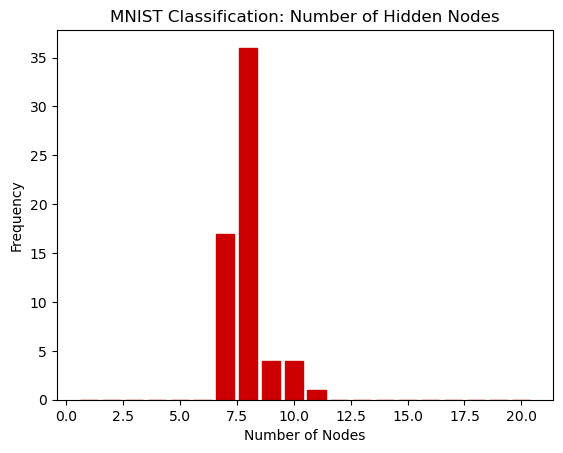

In [49]:
#Node Count Histogram

#########################
#Bar Plot of k estimates#
#########################

ks = [traces[i][(:k,1)] for i in 1:length(traces)]
counts = [sum([ks[i] == j for i in 1:length(ks)]) for j in k_list]

barlist=bar(k_list,counts)
for i in 1:k_range
    barlist[i].set_color([0.8,0.0,0.0])
end
#barlist[2].set_color([0.0,0.8,0.1])

plt.title("MNIST Classification: Number of Hidden Nodes")
plt.xlabel("Number of Nodes")
plt.ylabel("Frequency");

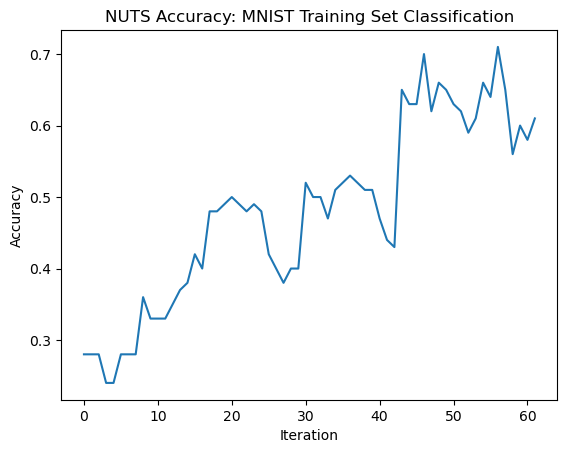

In [50]:
#Plot Training Accuracy
accs = []
dists = []
for i = 1:length(traces)
    trace = traces[i]
    test_labels = G(xt,trace)
    results = label_output(test_labels)
    test_acc = sum([y[i] == results[i] for i=1:length(y)])/length(y)
    test_dist = sum([euclidean(yt[:,j],test_labels[:,j]) for j=1:length(y)])
    push!(accs,test_acc)
    push!(dists,test_dist)
end

plot(accs)
plt.title("NUTS Accuracy: MNIST Training Set Classification")
plt.xlabel("Iteration")
plt.ylabel("Accuracy");

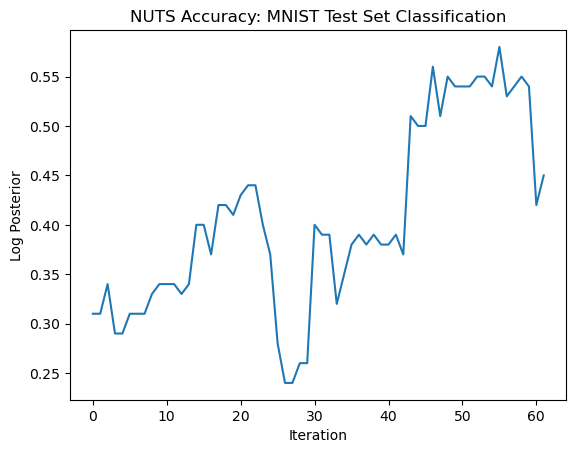

In [51]:
#Plot Testing Accuracy
accs = []
#dists = []
for i = 1:length(traces)
    trace = traces[i]
    test_labels = G(xz,trace)
    results = label_output(test_labels)
    test_acc = sum([y_test[i] == results[i] for i=1:length(y_test)])/length(y_test)
    test_dist = sum([euclidean(yzt[:,j],test_labels[:,j]) for j=1:length(y)])
    push!(accs,test_acc)
    #push!(dists,test_dist)
end

plot(accs)
plt.title("NUTS Accuracy: MNIST Test Set Classification")
plt.xlabel("Iteration")
plt.ylabel("Log Posterior");

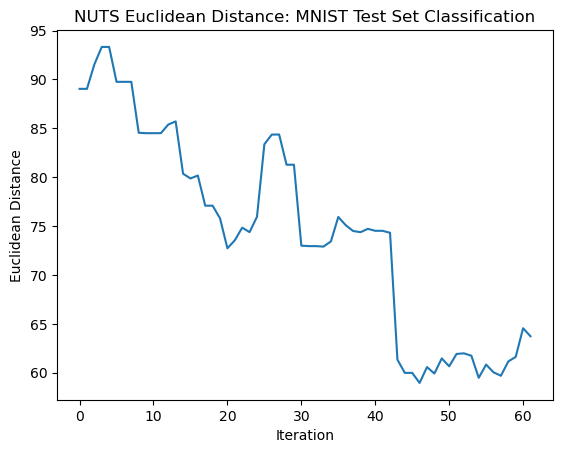

In [52]:
#Euclidean Distance
plot(dists)
plt.title("NUTS Euclidean Distance: MNIST Test Set Classification")
plt.xlabel("Iteration")
plt.ylabel("Euclidean Distance");

In [53]:
#Marginalize Probabilities - Train Set
j = 1
targets = zeros(length(traces)-j,c,N)
for i=j:length(traces)-j
    trace = traces[i]
    labels = G(xt,trace)
    targets[i-j+1,:,:] = labels
end

sums = sum(targets,dims=1)[1,:,:]./(length(traces)-j)
guesses = [findmax(sums[:,i])[2] for i=1:N]
test_acc = sum([y[i] == guesses[i] for i=1:length(y)])
println("Training set accuracy: $test_acc")

#Marginalize Probabilities - Test Set
j = 1
targets = zeros(length(traces)-j,c,N)
for i=j:length(traces)-j
    trace = traces[i]
    labels = G(xz,trace)
    targets[i-j+1,:,:] = labels
end

sums = sum(targets,dims=1)[1,:,:]./(length(traces)-j)
guesses = [findmax(sums[:,i])[2] for i=1:N]
test_acc = sum([yz[i] == guesses[i] for i=1:length(yz)])
println("Test set accuracy: $test_acc")

Training set accuracy: 61
Test set accuracy: 52


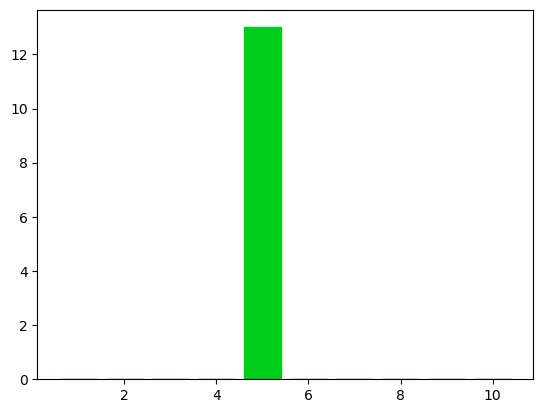

In [54]:
#Bar Chart of Guesses For Given Target
targets = []
target = 43
for i=50:length(traces)
    trace = traces[i]
    test_labels = G(xt,trace)
    results = label_output(test_labels)
    push!(targets,results[target])
end
#counts = [sum([ks[i] == j for i in 1:length(ks)]) for j in k_list]
counts = [sum([targets[i] == j for i in 1:length(targets)]) for j in 1:10]

barlist=bar(1:10,counts)
for i in 1:10
    barlist[i].set_color([0.8,0.0,0.0])
end
barlist[y[target]].set_color([0.0,0.8,0.1])
#println(targets)
#println(y[target])